In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn import preprocessing
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
dataset1=r'2.1.xlsx'
dataset=pd.read_excel(dataset1,engine='openpyxl')
dataset.head()

Cement     FA  GGBFS  SF  Kaolin  Other SCM    CA V    FA V  Na2SiO3(l)  \
0     0.0  476.0    0.0   0     0.0        0.0  497.69  213.08        48.0   
1     0.0  476.0    0.0   0     0.0        0.0  497.69  213.08       120.0   
2     0.0  476.0    0.0   0     0.0        0.0  497.69  213.08       120.0   
3     0.0  476.0    0.0   0     0.0        0.0  497.69  213.08       120.0   
4     0.0  476.0    0.0   0     0.0        0.0  497.69  213.08       120.0   

   NaOH(l)  Additional water  Superplasticizer             E  \
0    120.0               0.0               0.0  5.880000e+07   
1     48.0               0.0               0.0  1.400000e+06   
2     48.0               0.0               0.0  9.800000e+06   
3     48.0               0.0               0.0  1.820000e+07   
4     48.0               0.0               0.0  8.400000e+06   

   Initial curing H  day  type    fc  
0                20    7     2  17.0  
1                20    7     2   8.0  
2                20    7     2  24.0  
3                20    7     2  37.0  
4                20    7     2  20.0

In [4]:
X = dataset.loc[:, dataset.columns != 'fc']
y = dataset.loc[:, 'fc']

(3390, 16)
(3390,)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test_validation, y_train, y_test_validation = train_test_split(X, y, test_size=0.40, random_state=10)
X_test,X_validation,y_test,y_validation = train_test_split(X_test_validation, y_test_validation, test_size=0.50, random_state=10)

# Random forest

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

regr_1 = RandomForestRegressor(n_estimators=435, max_depth=31, max_leaf_nodes=719, min_samples_leaf=2, 
                               min_samples_split=2, bootstrap= False, random_state=0, max_features=6)

scores = cross_val_score (regr_1, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1)
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 7.047000124989014


In [8]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 

def MAPE(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / true)

regr_1.fit(X_train, y_train)

Z1 = regr_1.predict(X_train)
Z2 = regr_1.predict(X_test)
Z3 = regr_1.predict(X_validation)

print("Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)),
      "MAE:", mean_absolute_error(y_train, Z1), "MAPE:", MAPE(y_train, Z1))
print("Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)),
      "MAE:", mean_absolute_error(y_test, Z2), "MAPE:", MAPE(y_test, Z2))
print("Testing R2:", r2_score(y_validation, Z3), "RMSE:", np.sqrt(mean_squared_error(y_validation, Z3)),
      "MAE:", mean_absolute_error(y_validation, Z3), "MAPE:", MAPE(y_validation, Z3))

Training R2: 0.9486177042295296 RMSE: 3.5733946686826616 MAE: 2.1565303474962687 MAPE: 0.09366955861176708
Testing R2: 0.7682562254754345 RMSE: 7.941114300516939 MAE: 5.029592740040006 MAPE: inf
Testing R2: 0.809468884300096 RMSE: 6.826855234875247 MAE: 4.59493463904831 MAPE: inf


In [9]:
RF_r2,RF_RMSE,RF_MAE,RF_MAPE=[],[],[],[]
RF_r2.append(r2_score(y_train, Z1))
RF_r2.append(r2_score(y_test, Z2))
RF_r2.append(r2_score(y_validation, Z3))
RF_RMSE.append(np.sqrt(mean_squared_error(y_train, Z1)))
RF_RMSE.append(np.sqrt(mean_squared_error(y_test, Z2)))
RF_RMSE.append(np.sqrt(mean_squared_error(y_validation, Z3)))
RF_MAE.append(mean_absolute_error(y_train, Z1))
RF_MAE.append(mean_absolute_error(y_test, Z2))
RF_MAE.append(mean_absolute_error(y_validation, Z3))

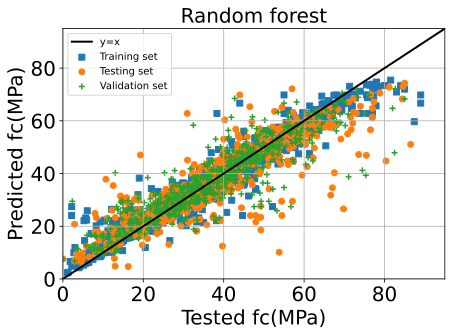

In [10]:
import matplotlib.pyplot as plt

xx = np.linspace(0, 100, 10)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')
plt.scatter(y_validation, Z3, marker='+')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set','Validation set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested fc(MPa)', fontsize=20)
plt.ylabel('Predicted fc(MPa)', fontsize=20)
plt.xlim([0, 95])
plt.ylim([0, 95])
plt.title('Random forest', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('R1.svg',dpi=300,bbox_inches="tight")
plt.show()

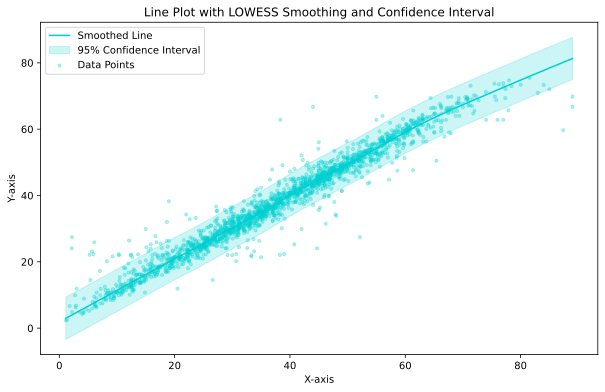

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_train, 'y': Z1})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z1, y_train, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z1 - np.interp(y_train, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#00CED1')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#00CED1', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_train, Z1, color='#00CED1', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('R11.svg',dpi=300,bbox_inches="tight")
plt.show()

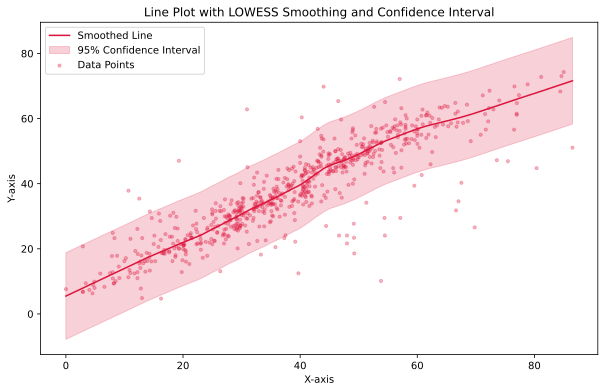

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_test, 'y': Z2})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z2, y_test, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z2 - np.interp(y_test, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#DC143C')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#DC143C', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_test, Z2, color='#DC143C', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('R12.svg',dpi=300,bbox_inches="tight")
plt.show()

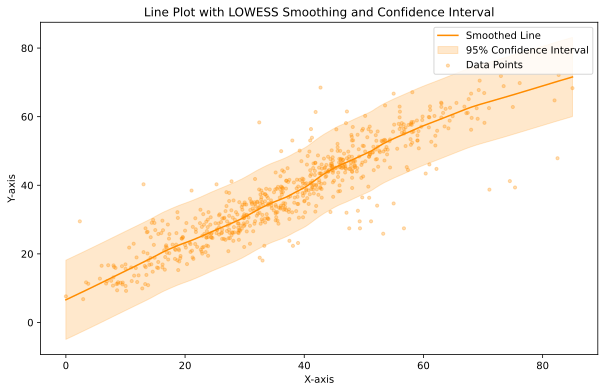

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_validation, 'y': Z3})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z3, y_validation, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z3 - np.interp(y_validation, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#FF8C00')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#FF8C00', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_validation, Z3, color='#FF8C00', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('R13.svg',dpi=300,bbox_inches="tight")
plt.show()

# AdaBoost

In [14]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

regr_2 = AdaBoostRegressor (tree.DecisionTreeRegressor(max_depth=24, min_samples_split=2, min_samples_leaf=3,
                                                       max_leaf_nodes=250, criterion='squared_error'),
                            n_estimators=310, learning_rate=0.1, random_state=0)


scores = cross_val_score (regr_2, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1, error_score='raise')
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 7.5992775739179965


In [15]:
regr_2.fit(X_train, y_train)

Z1 = regr_2.predict(X_train)
Z2 = regr_2.predict(X_test)
Z3 = regr_2.predict(X_validation)

print("Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)),
      "MAE:", mean_absolute_error(y_train, Z1), "MAPE:", MAPE(y_train, Z1))
print("Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)),
      "MAE:", mean_absolute_error(y_test, Z2), "MAPE:", MAPE(y_test, Z2))
print("Testing R2:", r2_score(y_validation, Z3), "RMSE:", np.sqrt(mean_squared_error(y_validation, Z3)),
      "MAE:", mean_absolute_error(y_validation, Z3), "MAPE:", MAPE(y_validation, Z3))

Training R2: 0.925702407710801 RMSE: 4.2969628883236775 MAE: 3.2244555098778203 MAPE: 0.14198586886607284
Testing R2: 0.7370498982890135 RMSE: 8.458903695096167 MAE: 5.713031831688382 MAPE: inf
Testing R2: 0.7781884363442716 RMSE: 7.3659680375937455 MAE: 5.20399934424712 MAPE: inf


In [16]:
AdaBoost_r2,AdaBoost_RMSE,AdaBoost_MAE,AdaBoost_MAPE=[],[],[],[]
AdaBoost_r2.append(r2_score(y_train, Z1))
AdaBoost_r2.append(r2_score(y_test, Z2))
AdaBoost_r2.append(r2_score(y_validation, Z3))
AdaBoost_RMSE.append(np.sqrt(mean_squared_error(y_train, Z1)))
AdaBoost_RMSE.append(np.sqrt(mean_squared_error(y_test, Z2)))
AdaBoost_RMSE.append(np.sqrt(mean_squared_error(y_validation, Z3)))
AdaBoost_MAE.append(mean_absolute_error(y_train, Z1))
AdaBoost_MAE.append(mean_absolute_error(y_test, Z2))
AdaBoost_MAE.append(mean_absolute_error(y_validation, Z3))

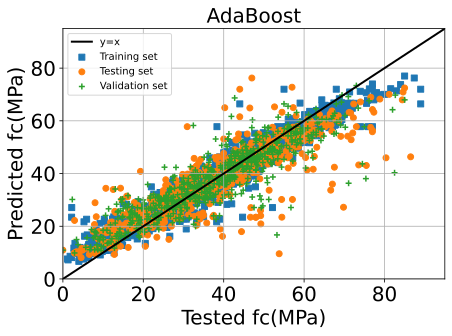

In [17]:
xx = np.linspace(0, 100, 10)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')
plt.scatter(y_validation, Z3, marker='+')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set','Validation set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested fc(MPa)', fontsize=20)
plt.ylabel('Predicted fc(MPa)', fontsize=20)
plt.xlim([0, 95])
plt.ylim([0, 95])
plt.title('AdaBoost', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('A1.svg',dpi=300,bbox_inches="tight")
plt.show()

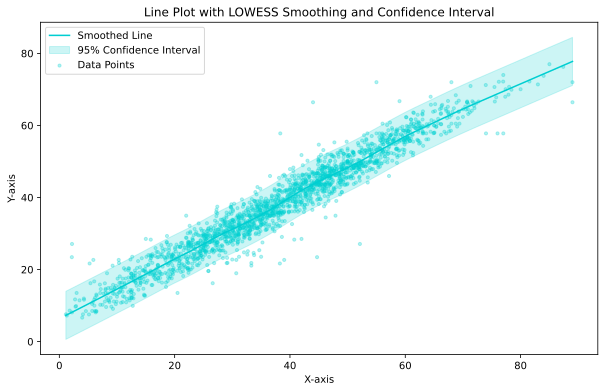

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_train, 'y': Z1})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z1, y_train, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z1 - np.interp(y_train, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#00CED1')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#00CED1', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_train, Z1, color='#00CED1', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('A11.svg',dpi=300,bbox_inches="tight")
plt.show()

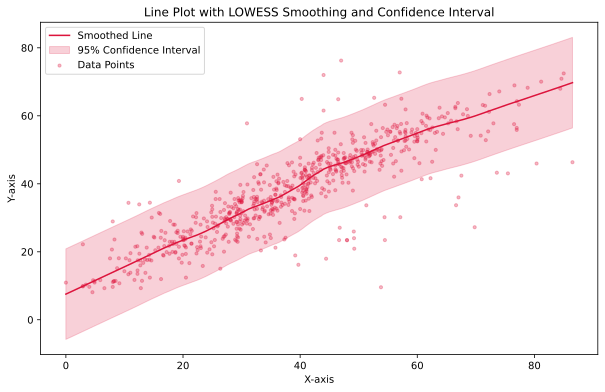

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_test, 'y': Z2})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z2, y_test, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z2 - np.interp(y_test, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#DC143C')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#DC143C', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_test, Z2, color='#DC143C', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()


# 显示图形
plt.savefig('A12.svg',dpi=300,bbox_inches="tight")
plt.show()

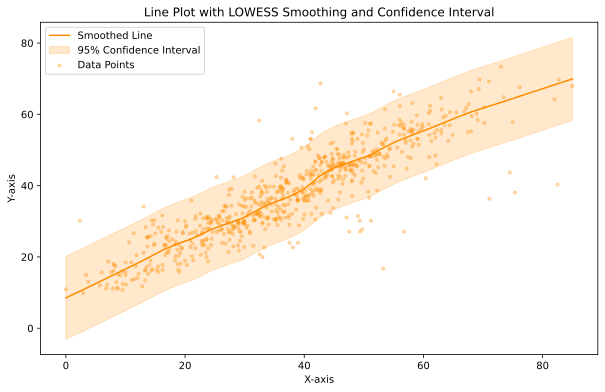

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_validation, 'y': Z3})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z3, y_validation, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z3 - np.interp(y_validation, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#FF8C00')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#FF8C00', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_validation, Z3, color='#FF8C00', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()


# 显示图形
plt.savefig('A13.svg',dpi=300,bbox_inches="tight")
plt.show()

# GBRT

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

regr_3 = GradientBoostingRegressor(n_estimators=136, learning_rate=0.21, max_depth=53, min_samples_leaf=9,
                                   min_samples_split=2, random_state=0, loss='squared_error')

scores = cross_val_score (regr_3, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1, error_score='raise')
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 7.1141748022329185


In [22]:
regr_3.fit(X_train, y_train)

Z1 = regr_3.predict(X_train)
Z2 = regr_3.predict(X_test)
Z3 = regr_3.predict(X_validation)

print("Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)),
      "MAE:", mean_absolute_error(y_train, Z1), "MAPE:", MAPE(y_train, Z1))
print("Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)),
      "MAE:", mean_absolute_error(y_test, Z2), "MAPE:", MAPE(y_test, Z2))
print("Testing R2:", r2_score(y_validation, Z3), "RMSE:", np.sqrt(mean_squared_error(y_validation, Z3)),
      "MAE:", mean_absolute_error(y_validation, Z3), "MAPE:", MAPE(y_validation, Z3))

Training R2: 0.97212083733869 RMSE: 2.632170973854211 MAE: 1.1046719102108666 MAPE: 0.051900976736516315
Testing R2: 0.74357492655279 RMSE: 8.35329181271195 MAE: 4.853218678642065 MAPE: inf
Testing R2: 0.7913521466626566 RMSE: 7.144053509094214 MAE: 4.533596634947172 MAPE: inf


In [23]:
GBRT_r2,GBRT_RMSE,GBRT_MAE,GBRT_MAPE=[],[],[],[]
GBRT_r2.append(r2_score(y_train, Z1))
GBRT_r2.append(r2_score(y_test, Z2))
GBRT_r2.append(r2_score(y_validation, Z3))
GBRT_RMSE.append(np.sqrt(mean_squared_error(y_train, Z1)))
GBRT_RMSE.append(np.sqrt(mean_squared_error(y_test, Z2)))
GBRT_RMSE.append(np.sqrt(mean_squared_error(y_validation, Z3)))
GBRT_MAE.append(mean_absolute_error(y_train, Z1))
GBRT_MAE.append(mean_absolute_error(y_test, Z2))
GBRT_MAE.append(mean_absolute_error(y_validation, Z3))

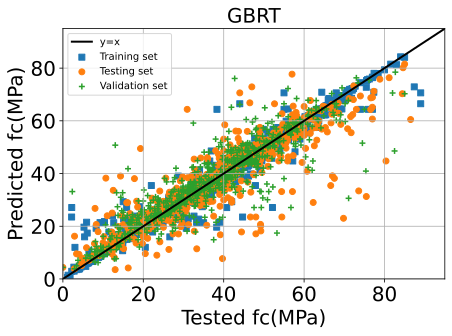

In [24]:
xx = np.linspace(0, 100, 10)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')
plt.scatter(y_validation, Z3, marker='+')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set','Validation set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested fc(MPa)', fontsize=20)
plt.ylabel('Predicted fc(MPa)', fontsize=20)
plt.xlim([0, 95])
plt.ylim([0, 95])
plt.title('GBRT', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('G1.svg',dpi=300,bbox_inches="tight")
plt.show()

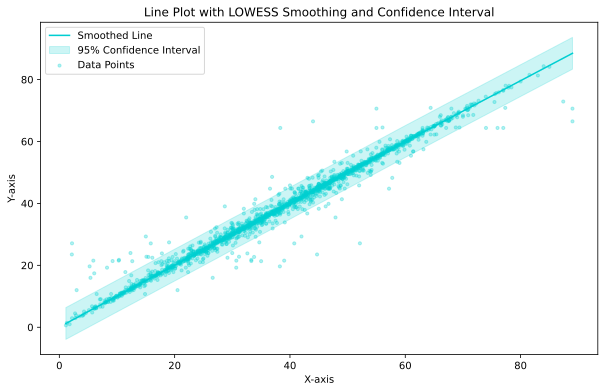

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_train, 'y': Z1})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z1, y_train, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z1 - np.interp(y_train, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#00CED1')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#00CED1', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_train, Z1, color='#00CED1', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('G11.svg',dpi=300,bbox_inches="tight")
plt.show()

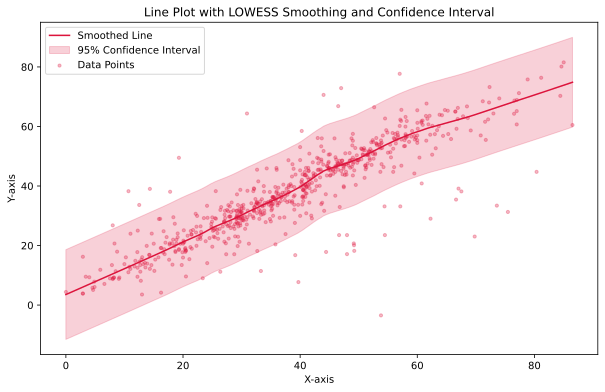

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_test, 'y': Z2})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z2, y_test, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z2 - np.interp(y_test, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#DC143C')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#DC143C', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_test, Z2, color='#DC143C', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('G12.svg',dpi=300,bbox_inches="tight")
plt.show()

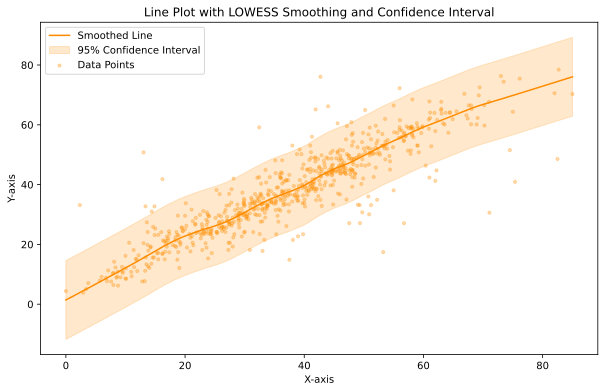

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_validation, 'y': Z3})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z3, y_validation, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z3 - np.interp(y_validation, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#FF8C00')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#FF8C00', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_validation, Z3, color='#FF8C00', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('G13.svg',dpi=300,bbox_inches="tight")
plt.show()

# XGBoost

In [28]:
regr_4 = xgb.XGBRegressor (max_depth=28, learning_rate=0.01, n_estimators=736, colsample_bytree=1, 
                           subsample=0.76, gamma=2, random_state=0)

scores = cross_val_score (regr_4, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1)
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 7.06591496863066


In [29]:
regr_4.fit(X_train, y_train)

Z1 = regr_4.predict(X_train)
Z2 = regr_4.predict(X_test)
Z3 = regr_4.predict(X_validation)

print("Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)),
      "MAE:", mean_absolute_error(y_train, Z1), "MAPE:", MAPE(y_train, Z1))
print("Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)),
      "MAE:", mean_absolute_error(y_test, Z2), "MAPE:", MAPE(y_test, Z2))
print("Testing R2:", r2_score(y_validation, Z3), "RMSE:", np.sqrt(mean_squared_error(y_validation, Z3)),
      "MAE:", mean_absolute_error(y_validation, Z3), "MAPE:", MAPE(y_validation, Z3))

Training R2: 0.9730565196125981 RMSE: 2.587623460407746 MAE: 1.2181705003459096 MAPE: 0.05405220257978812
Testing R2: 0.755198072685176 RMSE: 8.161778892461545 MAE: 4.801331585643883 MAPE: inf
Testing R2: 0.8081625686109444 RMSE: 6.85021833319105 MAE: 4.332699894889777 MAPE: inf


In [30]:
XGBoost_r2,XGBoost_RMSE,XGBoost_MAE,XGBoost_MAPE=[],[],[],[]
XGBoost_r2.append(r2_score(y_train, Z1))
XGBoost_r2.append(r2_score(y_test, Z2))
XGBoost_r2.append(r2_score(y_validation, Z3))
XGBoost_RMSE.append(np.sqrt(mean_squared_error(y_train, Z1)))
XGBoost_RMSE.append(np.sqrt(mean_squared_error(y_test, Z2)))
XGBoost_RMSE.append(np.sqrt(mean_squared_error(y_validation, Z3)))
XGBoost_MAE.append(mean_absolute_error(y_train, Z1))
XGBoost_MAE.append(mean_absolute_error(y_test, Z2))
XGBoost_MAE.append(mean_absolute_error(y_validation, Z3))

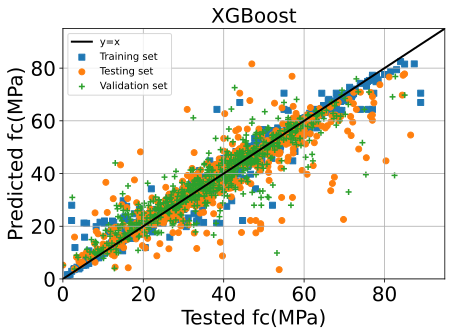

In [31]:
xx = np.linspace(0, 100, 10)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')
plt.scatter(y_validation, Z3, marker='+')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set','Validation set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested fc(MPa)', fontsize=20)
plt.ylabel('Predicted fc(MPa)', fontsize=20)
plt.xlim([0, 95])
plt.ylim([0, 95])
plt.title('XGBoost', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('X1.svg',dpi=300,bbox_inches="tight")
plt.show()

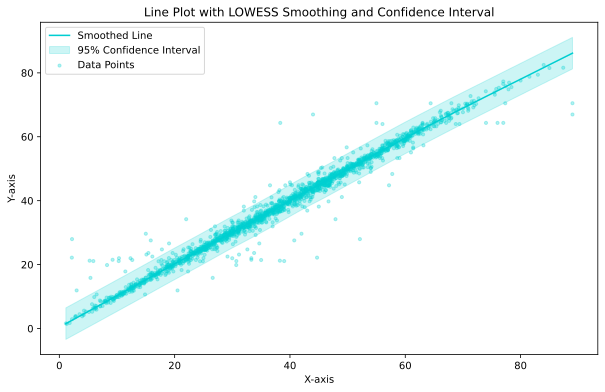

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_train, 'y': Z1})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z1, y_train, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z1 - np.interp(y_train, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#00CED1')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#00CED1', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_train, Z1, color='#00CED1', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('X11.svg',dpi=300,bbox_inches="tight")
plt.show()

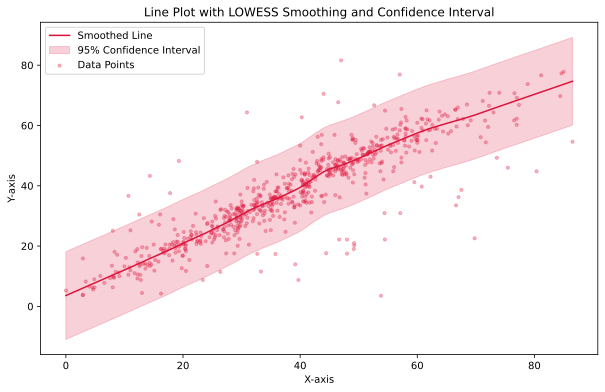

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_test, 'y': Z2})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z2, y_test, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z2 - np.interp(y_test, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#DC143C')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#DC143C', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_test, Z2, color='#DC143C', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('X12.svg',dpi=300,bbox_inches="tight")
plt.show()

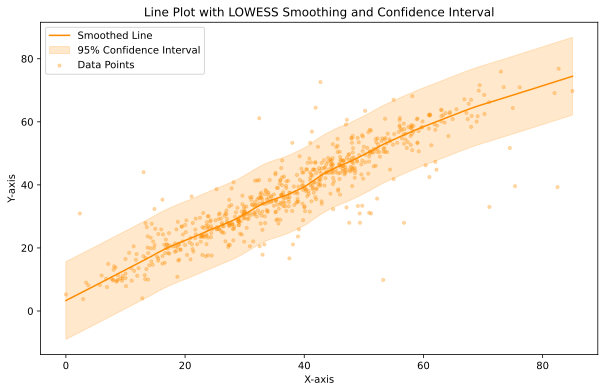

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_validation, 'y': Z3})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z3, y_validation, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z3 - np.interp(y_validation, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#FF8C00')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#FF8C00', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_validation, Z3, color='#FF8C00', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('X13.svg',dpi=300,bbox_inches="tight")
plt.show()

In [35]:
r2={'RF':RF_r2,'AdaBoost':AdaBoost_r2,'GBRT':GBRT_r2,'XGBoost':XGBoost_r2}
RMSE={'RF':RF_RMSE,'AdaBoost':AdaBoost_RMSE,'GBRT':GBRT_RMSE,'XGBoost':XGBoost_RMSE}
MAE={'RF':RF_MAE,'AdaBoost':AdaBoost_MAE,'GBRT':GBRT_MAE,'XGBoost':XGBoost_MAE}

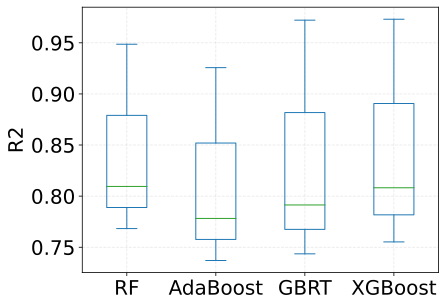

In [36]:
df_r2 = pd.DataFrame(r2)
df_r2.plot.box(fontsize=20)
plt.ylabel('R2', fontsize=20)
plt.grid(linestyle="--", alpha=0.3)
plt.savefig('C01.svg',dpi=300,bbox_inches="tight")
plt.show()

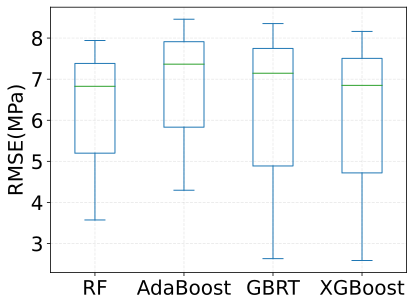

In [37]:
df_RMSE = pd.DataFrame(RMSE)
df_RMSE.plot.box(fontsize=20)
plt.ylabel('RMSE(MPa)', fontsize=20)
plt.grid(linestyle="--", alpha=0.3)
plt.savefig('C11.svg',dpi=300,bbox_inches="tight")
plt.show()

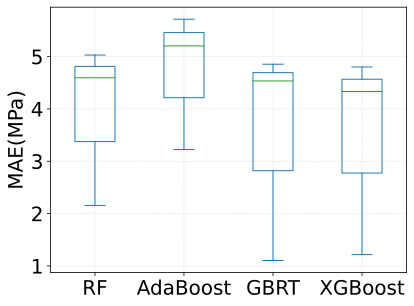

In [38]:
df_MAE = pd.DataFrame(MAE)
df_MAE.plot.box(fontsize=20)
plt.ylabel('MAE(MPa)', fontsize=20)
plt.grid(linestyle="--", alpha=0.3)
plt.savefig('C21.svg',dpi=300,bbox_inches="tight")
plt.show()